## Dependencies

In [76]:
from tqdm import tqdm
import statistics

import torch
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from sklearn.metrics import roc_auc_score, accuracy_score

import torch_geometric.transforms as T
from torch_geometric.datasets import SNAPDataset
from torch_geometric.nn import GCNConv, SAGEConv, GATConv, GINConv
from torch_geometric.utils import negative_sampling, to_networkx

torch.manual_seed(0)

%matplotlib notebook

## Data

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

orig_transform = T.Compose([
    T.ToDevice(device),
    T.RemoveIsolatedNodes(),
])

transform = T.Compose([
    T.ToDevice(device),
    T.RemoveIsolatedNodes(),
    T.RandomLinkSplit(
        num_val=0.05, 
        num_test=0.1, 
        is_undirected=True, 
        add_negative_train_samples=False
    ),
])

orig_dataset = SNAPDataset(root="../data/SNAPDataset", name="ego-facebook", transform=orig_transform)
dataset = SNAPDataset(root="../data/SNAPDataset", name="ego-facebook", transform=transform)

data = orig_dataset[0]
train_data, val_data, test_data = dataset[0]

In [3]:
print(data)
print(train_data)
print(val_data)
print(test_data)

Data(x=[347, 1406], edge_index=[2, 5718], circle=[325], circle_batch=[325])
Data(x=[347, 1406], edge_index=[2, 4864], circle=[325], circle_batch=[325], edge_label=[2432], edge_label_index=[2, 2432])
Data(x=[347, 1406], edge_index=[2, 4864], circle=[325], circle_batch=[325], edge_label=[284], edge_label_index=[2, 284])
Data(x=[347, 1406], edge_index=[2, 5148], circle=[325], circle_batch=[325], edge_label=[570], edge_label_index=[2, 570])


## Prediction

In [4]:
from torch import nn
import torch.nn.functional as F


class SimpleNet(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def encode(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv2(x, edge_index)

    def decode(self, z, edge_label_index):
        return (z[edge_label_index[0]] * z[edge_label_index[1]]).sum(dim=-1)
    
    def forward(self, x, edge_index, data=None):
        z = self.encode(x, edge_index)
        out = model.decode(z, edge_index)
        return torch.hstack((-out, out)).T


class Net(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        # TODO: look into SAGEConv, GATConv, GINConv, comparison between
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)
        
        self.W1 = nn.Linear(out_channels * 2, out_channels)
        self.W2 = nn.Linear(out_channels, 1)

    def encode(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv2(x, edge_index)

    def decode(self, z, edge_label_index):
        z1 = torch.cat((z[edge_label_index[0]], z[edge_label_index[1]]), dim=1)
        out1 = self.W2(F.relu(self.W1(z1)).squeeze())
        
        z2 = torch.cat((z[edge_label_index[1]], z[edge_label_index[0]]), dim=1)
        out2 = self.W2(F.relu(self.W1(z2)).squeeze())
        
        return (out1 + out2) / 2
    
    def forward(self, x, edge_index, edge_label_index, data=None):
        z = self.encode(x, edge_index)
        out = model.decode(z, edge_label_index)
        return torch.hstack((-out, out)).T

simple_model = SimpleNet(dataset.num_features, 128, 32).to(device)
simple_optimizer = torch.optim.Adam(params=simple_model.parameters(), lr=3e-3)
    
model = Net(dataset.num_features, 128, 32).to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=3e-3)
criterion = torch.nn.BCEWithLogitsLoss()

# TODO: These methods simultaneously use node feature and graph structure properties.
#       Is it possible to train models that look at each aspect separately
#       Can look at only node features by just passing original layer to MLP
#       Unsure if can look at only graph by passing random vector into GCNConv
#       Should also read up on Node2Vec and other methods of generating node embeddings (talk to Rex)

In [5]:
def train(model, optimizer, data):
    model.train()
    optimizer.zero_grad()
    z = model.encode(data.x, data.edge_index)

    # We perform a new round of negative sampling for every training epoch:
    neg_edge_index = negative_sampling(
        edge_index=data.edge_index, 
        num_nodes=data.num_nodes,
        num_neg_samples=data.edge_label_index.shape[1], 
        method='sparse'
    )
    
    edge_label_index = torch.cat([data.edge_label_index, neg_edge_index], dim=-1)
    edge_label = torch.cat([data.edge_label, data.edge_label.new_zeros(neg_edge_index.size(1))], dim=0)

    out = model.decode(z, edge_label_index).view(-1)
    loss = criterion(out, edge_label)
    loss.backward()
    optimizer.step()
    return loss


@torch.no_grad()
def test(model, data):
    model.eval()
    z = model.encode(data.x, data.edge_index)
    out = model.decode(z, data.edge_label_index).view(-1).sigmoid()
    a, b = data.edge_label.cpu().numpy(), out.cpu().numpy()
    c = (out > 0.5).float().cpu().numpy()
    return roc_auc_score(a, b), accuracy_score(a, c)

In [6]:
best_val_auc = final_test_auc = final_test_acc = 0
for epoch in range(1, 1001):
    loss = train(simple_model, simple_optimizer, train_data)
    val_auc, val_acc = test(simple_model, val_data)
    test_auc, test_acc = test(simple_model, test_data)
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        final_test_auc = test_auc
        final_test_acc = test_acc
    if epoch % 50 == 0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_auc:.4f} {val_acc:.4f}, Test: {test_auc:.4f} {test_acc:.4f}')

print(f'Final Test: {final_test_auc:.4f} {final_test_acc:.4f}')

simple_z = simple_model.encode(test_data.x, test_data.edge_index)
simple_final_edge_index = simple_model.decode(simple_z, test_data.edge_label_index)

Epoch: 050, Loss: 0.4783, Val: 0.9254 0.7746, Test: 0.9087 0.7474
Epoch: 100, Loss: 0.4628, Val: 0.9343 0.7782, Test: 0.9195 0.7596
Epoch: 150, Loss: 0.4482, Val: 0.9246 0.7641, Test: 0.9125 0.7684
Epoch: 200, Loss: 0.4427, Val: 0.9147 0.7606, Test: 0.9100 0.7596
Epoch: 250, Loss: 0.4426, Val: 0.9124 0.7676, Test: 0.9049 0.7649
Epoch: 300, Loss: 0.4354, Val: 0.9091 0.7887, Test: 0.9002 0.7596
Epoch: 350, Loss: 0.4318, Val: 0.9101 0.7993, Test: 0.8958 0.7509
Epoch: 400, Loss: 0.4324, Val: 0.9124 0.8169, Test: 0.8938 0.7596
Epoch: 450, Loss: 0.4215, Val: 0.9010 0.7923, Test: 0.8875 0.7614
Epoch: 500, Loss: 0.4040, Val: 0.9124 0.8169, Test: 0.8951 0.7667
Epoch: 550, Loss: 0.4173, Val: 0.9101 0.8063, Test: 0.8911 0.7737
Epoch: 600, Loss: 0.4082, Val: 0.9022 0.7993, Test: 0.8869 0.7719
Epoch: 650, Loss: 0.4076, Val: 0.9072 0.7887, Test: 0.8917 0.7614
Epoch: 700, Loss: 0.3975, Val: 0.9000 0.7817, Test: 0.8851 0.7667
Epoch: 750, Loss: 0.4027, Val: 0.9055 0.8099, Test: 0.8911 0.7719
Epoch: 800

In [7]:
best_val_auc = final_test_auc = final_test_acc = 0
for epoch in range(1, 1001):
    loss = train(model, optimizer, train_data)
    val_auc, val_acc = test(model, val_data)
    test_auc, test_acc = test(model, test_data)
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        final_test_auc = test_auc
        final_test_acc = test_acc
    if epoch % 50 == 0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_auc:.4f} {val_acc:.4f}, Test: {test_auc:.4f} {test_acc:.4f}')

print(f'Final Test: {final_test_auc:.4f} {final_test_acc:.4f}')

z = model.encode(test_data.x, test_data.edge_index)
final_edge_index = model.decode(z, test_data.edge_label_index)

Epoch: 050, Loss: 0.4025, Val: 0.9421 0.8662, Test: 0.9091 0.8193
Epoch: 100, Loss: 0.3078, Val: 0.9426 0.8803, Test: 0.9488 0.8825
Epoch: 150, Loss: 0.2697, Val: 0.9453 0.8768, Test: 0.9538 0.8860
Epoch: 200, Loss: 0.2738, Val: 0.9470 0.8803, Test: 0.9544 0.8807
Epoch: 250, Loss: 0.2566, Val: 0.9486 0.8873, Test: 0.9538 0.8877
Epoch: 300, Loss: 0.2522, Val: 0.9508 0.8838, Test: 0.9528 0.8789
Epoch: 350, Loss: 0.2481, Val: 0.9524 0.8873, Test: 0.9521 0.8842
Epoch: 400, Loss: 0.2914, Val: 0.9534 0.8944, Test: 0.9515 0.8860
Epoch: 450, Loss: 0.2449, Val: 0.9549 0.8944, Test: 0.9506 0.8860
Epoch: 500, Loss: 0.2354, Val: 0.9552 0.8873, Test: 0.9512 0.8842
Epoch: 550, Loss: 0.2423, Val: 0.9560 0.8944, Test: 0.9519 0.8895
Epoch: 600, Loss: 0.2297, Val: 0.9564 0.8908, Test: 0.9519 0.8895
Epoch: 650, Loss: 0.2415, Val: 0.9565 0.8873, Test: 0.9524 0.8895
Epoch: 700, Loss: 0.2280, Val: 0.9574 0.8873, Test: 0.9533 0.8860
Epoch: 750, Loss: 0.2226, Val: 0.9568 0.9014, Test: 0.9549 0.8789
Epoch: 800

In [8]:
(test_data.edge_label == (torch.sigmoid(simple_final_edge_index.squeeze()) > 0.7)).sum() / test_data.edge_label.shape[0]

tensor(0.8754)

In [9]:
(test_data.edge_label == (torch.sigmoid(final_edge_index.squeeze()) > 0.5)).sum() / test_data.edge_label.shape[0]

tensor(0.8860)

In [10]:
simple_model.forward(test_data.x, test_data.edge_index, test_data.edge_label_index)

tensor([[ 0.6196,  0.8242,  0.1174,  ...,  1.0331,  0.6589,  0.9623],
        [-0.6196, -0.8242, -0.1174,  ..., -1.0331, -0.6589, -0.9623]],
       grad_fn=<PermuteBackward0>)

In [11]:
model.forward(test_data.x, test_data.edge_index, test_data.edge_label_index)

tensor([[-7.9571, -1.3791, -1.2422,  ...,  5.2593,  8.3619, -0.4919],
        [ 7.9571,  1.3791,  1.2422,  ..., -5.2593, -8.3619,  0.4919]],
       grad_fn=<PermuteBackward0>)

## Exploration

In [12]:
test_data.edge_label_index[:, 12]

tensor([ 24, 187])

In [13]:
node_1 = 24
node_2 = 187

node_1_neighbors = set(test_data.edge_index[:, (test_data.edge_index[0] == node_1)][1].cpu().numpy())
node_2_neighbors = set(test_data.edge_index[:, (test_data.edge_index[0] == node_2)][1].cpu().numpy())

print("Node 1 Neighbors:", node_1_neighbors)
print("Node 2 Neighbors:", node_2_neighbors)
print("Overlapping Neighbors:", node_1_neighbors.intersection(node_2_neighbors))

Node 1 Neighbors: {256, 129, 2, 269, 270, 271, 275, 147, 276, 20, 279, 25, 282, 157, 30, 289, 290, 38, 39, 168, 169, 296, 175, 50, 55, 184, 185, 64, 321, 66, 322, 324, 68, 198, 71, 199, 72, 330, 75, 331, 335, 82, 83, 87, 346, 220, 93, 223, 97, 230, 231, 103, 102, 104, 235, 236, 238, 112, 245, 121}
Node 2 Neighbors: {257, 2, 132, 8, 12, 141, 270, 271, 273, 276, 20, 279, 25, 155, 284, 29, 289, 290, 164, 296, 169, 303, 175, 55, 184, 185, 314, 321, 322, 66, 199, 74, 333, 78, 207, 84, 341, 222, 103, 238, 112, 118, 121, 251}
Overlapping Neighbors: {2, 270, 271, 276, 20, 279, 25, 289, 290, 296, 169, 175, 55, 184, 185, 321, 322, 66, 199, 103, 238, 112, 121}


<IPython.core.display.Javascript object>


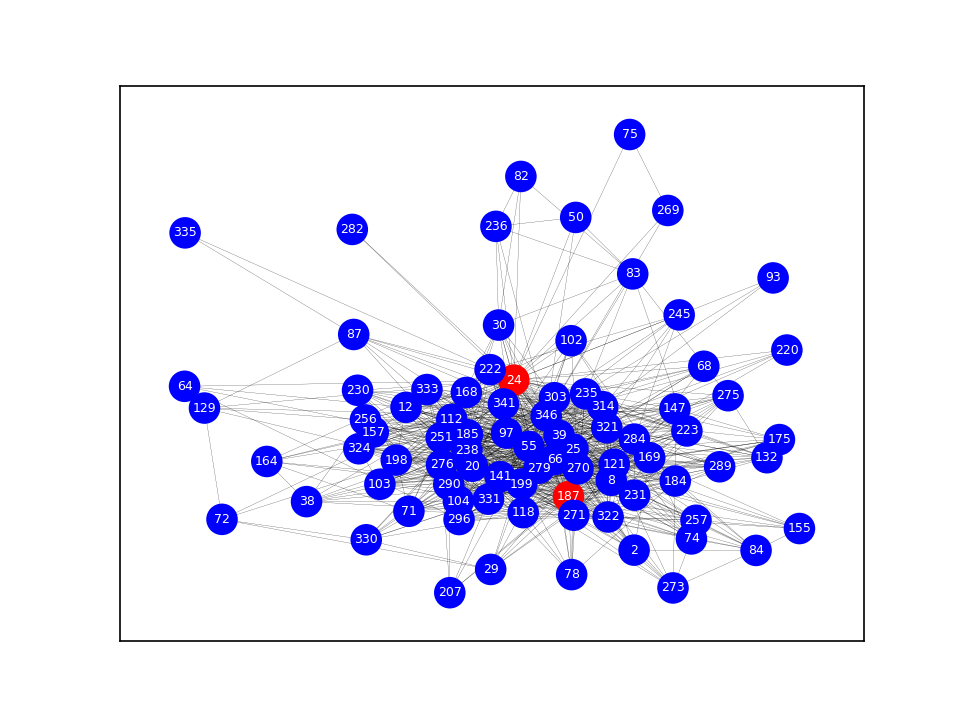

In [14]:
nodes = [node_1, node_2] + list(node_1_neighbors.union(node_2_neighbors))
colors = ["red", "red"] + ["blue" for _ in nodes[2:]]

fig, ax = plt.subplots()
g = to_networkx(test_data, to_undirected=True)
h = g.subgraph(nodes)
nx.draw_networkx(h, node_size=200, nodelist=nodes, node_color=colors, width=0.1, font_color="white", font_size=6)
plt.show()

In [15]:
old_z = model.encode(test_data.x, test_data.edge_index)
old_pred = model.decode(old_z, torch.tensor([[node_1], [node_2]]))
print(old_pred)

tensor([5.4442], grad_fn=<DivBackward0>)


In [16]:
for neighbor in node_1_neighbors.union(node_2_neighbors):
    temp_x = test_data.x.clone()
    temp_x[neighbor] = 0
    new_z = model.encode(temp_x, test_data.edge_index)
    new_pred = model.decode(new_z, torch.tensor([[node_1], [node_2]]))
    print(neighbor, "\t", round(new_pred.item(), 5))

256 	 5.43309
257 	 5.35379
2 	 5.44509
8 	 5.41302
12 	 5.39019
269 	 5.67303
270 	 5.39058
271 	 5.29939
273 	 5.46035
275 	 5.462
276 	 5.41883
20 	 5.36681
279 	 5.43497
25 	 5.42986
282 	 5.41615
284 	 5.23093
29 	 5.44176
30 	 5.41343
289 	 5.3987
290 	 5.46924
38 	 5.45441
39 	 5.33165
296 	 5.50991
303 	 5.45273
50 	 5.47983
55 	 5.40638
314 	 5.48006
64 	 5.43543
321 	 5.43554
66 	 5.38461
322 	 5.34365
324 	 5.43557
68 	 5.44659
71 	 5.40097
72 	 5.36764
330 	 5.47565
75 	 5.45059
331 	 5.53264
74 	 5.43995
333 	 5.44712
335 	 5.55389
78 	 5.44954
82 	 5.44163
83 	 5.31087
84 	 5.46343
341 	 5.45372
87 	 5.48092
346 	 5.2275
93 	 5.44742
97 	 5.43108
102 	 5.45555
103 	 5.4221
104 	 5.46614
112 	 5.39886
118 	 5.33808
121 	 5.41906
129 	 5.43596
132 	 5.43284
141 	 5.42406
147 	 5.49599
155 	 5.24973
157 	 5.42324
164 	 5.47644
168 	 5.39111
169 	 5.45383
175 	 5.40859
184 	 5.42925
185 	 5.42559
198 	 5.3887
199 	 5.52849
207 	 5.49709
220 	 5.43885
222 	 5.41824
223 	 5.444

In [17]:
# Start implementing GNNExplainer, PGExplainer, and SubgraphX architectures with 1-hop subgraph as parameters
# Think about separately learning node feature explanations

## GNNExplainer

In [18]:
from math import sqrt

from torch_geometric.nn import GNNExplainer
from torch_geometric.nn.models.explainer import clear_masks, set_masks
from torch_geometric.utils import k_hop_subgraph

EPS = 1e-15


class EdgeGNNExplainer(GNNExplainer):
    coeffs = {
        'edge_size': 0.10,  # 0.005
        'edge_reduction': 'sum',  # sum
        'edge_ent': 1.0,  # 1.0
    }
    
    def _initialize_masks(self, x, edge_index, sub_edge_mask=None, init="normal"):
        (N, F), E = x.size(), edge_index.size(1)
        self.node_feat_mask = torch.nn.Parameter(100 * torch.ones(1, F))
        
        std = torch.nn.init.calculate_gain('relu') * sqrt(2.0 / (2 * N))
        if sub_edge_mask is None:
            self.edge_mask = torch.nn.Parameter(torch.randn(E) * std)
        else:
            E_1, mask = sub_edge_mask.sum(), 100 * torch.ones(E)
            mask[sub_edge_mask] = torch.randn(E_1) * std
            self.edge_mask = torch.nn.Parameter(mask)  
    
    def _loss(self, log_logits, prediction, node_idx = None):
        error_loss = -log_logits[prediction]
                
        m = self.edge_mask[self.sub_edge_mask].sigmoid()
        edge_reduce = getattr(torch, self.coeffs['edge_reduction'])
        edge_size_loss = edge_reduce(m)
        ent = -m * torch.log(m + EPS) - (1 - m) * torch.log(1 - m + EPS)
        edge_ent_loss = ent.mean()

        loss = (
            error_loss + 
            self.coeffs['edge_size'] * edge_size_loss + 
            self.coeffs['edge_ent'] * edge_ent_loss
        )
        
        print(
            round(error_loss.item(), 4), "  \t", 
            round(edge_size_loss.item(), 4), "  \t", 
            round(edge_ent_loss.item(), 4), "  \t",
            round(loss.item(), 4), "  \t"
        )
        
        return loss
    
    """
    # Alternative loss function that tries to simultaneously optimize constraints
    # From qualitative testing, seems to better satisfy both constraints
    def _loss(self, log_logits, prediction, node_idx = None):
        error_loss = -log_logits[prediction].clip(-6, 6)
                
        m = self.edge_mask[self.sub_edge_mask].sigmoid()
        edge_reduce = getattr(torch, self.coeffs['edge_reduction'])
        edge_size_loss = edge_reduce(m)
        ent = -m * torch.log(m + EPS) - (1 - m) * torch.log(1 - m + EPS)
        edge_ent_loss = ent.mean()

        loss = - (1 - (error_loss + 6) / 12) * (1 - torch.mean(m)) + 0.1 * edge_ent_loss
        
        print(
            round(error_loss.item(), 4), "  \t", 
            round(edge_size_loss.item(), 4), "  \t", 
            round(edge_ent_loss.item(), 4), "  \t",
            round(loss.item(), 4), "  \t"
        )
        
        return loss
    """
    
    def subgraph(self, node_idx_1, node_idx_2, x, edge_index, **kwargs):
        num_nodes, num_edges = x.size(0), edge_index.size(1)
        
        subset_1, edge_index_1, _, edge_mask_1 = k_hop_subgraph(
            node_idx_1, self.num_hops, edge_index, num_nodes=num_nodes, flow=self._flow()
        )
        subset_2, edge_index_2, _, edge_mask_2 = k_hop_subgraph(
            node_idx_2, self.num_hops, edge_index, num_nodes=num_nodes, flow=self._flow()
        )
        
        # Combines two node-centered subgraphs
        temp_node_idx = edge_index[0].new_full((num_nodes,), -1)  # full size
        edge_mask = edge_mask_1 | edge_mask_2
        edge_index = edge_index[:, edge_mask]  # filters out edges
        subset = torch.cat((subset_1, subset_2)).unique()
        temp_node_idx[subset] = torch.arange(subset.size(0), device=edge_index.device)
        edge_index = temp_node_idx[edge_index]  # maps edge_index to [0, n]
        x = x[subset]  # filters out nodes
        mapping = torch.tensor([
            (subset == node_idx_1).nonzero().item(), 
            (subset == node_idx_2).nonzero().item(),
        ])
        
        # Only optimizes the edges from neighbors to node_1/node_2, other direction not needed for prediction
        sub_edge_mask = (edge_index[1] == mapping[0]) |  (edge_index[1] == mapping[1])
        
        return x, edge_index, mapping, edge_mask, subset, sub_edge_mask
    
    def explain_edge(self, node_idx_1, node_idx_2, x, edge_index, **kwargs):
        self.model.eval()
        self._clear_masks()

        num_nodes, num_edges = x.size(0), edge_index.size(1)
        
        # Only operate on a k-hop subgraph around `node_idx_1` and `node_idx_2.
        x, edge_index, mapping, hard_edge_mask, subset, sub_edge_mask = \
            self.subgraph(node_idx_1, node_idx_2, x, edge_index)
        self.sub_edge_mask = sub_edge_mask
        edge_label_index=mapping.unsqueeze(1)
        
        # Get the initial prediction
        prediction = self.get_initial_prediction(x, edge_index, edge_label_index=edge_label_index)
        
        self._initialize_masks(x, edge_index, sub_edge_mask)
        self.to(x.device)

        set_masks(self.model, self.edge_mask, edge_index, apply_sigmoid=True)
        optimizer = torch.optim.Adam([self.edge_mask], lr=self.lr)

        for epoch in range(1, self.epochs + 1):
            optimizer.zero_grad()
            out = self.model(x=x, edge_index=edge_index, edge_label_index=edge_label_index)
            loss = self.get_loss(out, prediction, mapping).mean()
            loss.backward()
            optimizer.step()

        edge_mask = self.edge_mask.new_zeros(num_edges)
        edge_mask[hard_edge_mask] = self.edge_mask.detach().sigmoid()
        
        self._clear_masks()

        return edge_mask

In [19]:
x = test_data.x
edge_index = test_data.edge_index

node_idx_1 = node_1  # test_data.edge_label_index[0, 0].item()
node_idx_2 = node_2  # test_data.edge_label_index[1, 0].item()

print(node_idx_1, node_idx_2)

explainer = EdgeGNNExplainer(model, epochs=200, lr=0.1)
edge_mask = explainer.explain_edge(node_idx_1, node_idx_2, x, edge_index)

print("Done!")

24 187
-0.1127   	 51.6268   	 0.6925   	 5.7425   	
-0.203   	 51.4279   	 0.6915   	 5.6313   	
-0.2929   	 51.2295   	 0.688   	 5.5181   	
-0.3484   	 51.0347   	 0.6822   	 5.4372   	
-0.3223   	 50.701   	 0.6753   	 5.4231   	


C:\Users\Abhijit\AppData\Local\Temp\ipykernel_12276\81617139.py:50: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:2985.)
  return torch.hstack((-out, out)).T


-0.3071   	 50.4226   	 0.669   	 5.4041   	
-0.3093   	 50.192   	 0.6628   	 5.3728   	
-0.3231   	 49.997   	 0.6566   	 5.3331   	
-0.3455   	 49.8299   	 0.65   	 5.2875   	
-0.3744   	 49.6862   	 0.6429   	 5.2372   	
-0.4085   	 49.563   	 0.6354   	 5.1832   	
-0.4468   	 49.4586   	 0.6272   	 5.1263   	
-0.4886   	 49.3718   	 0.6184   	 5.067   	
-0.5312   	 49.3019   	 0.6089   	 5.0079   	
-0.5506   	 49.2055   	 0.5982   	 4.9681   	
-0.5682   	 49.0889   	 0.5865   	 4.9272   	
-0.5841   	 48.9572   	 0.574   	 4.8856   	
-0.5985   	 48.8148   	 0.5608   	 4.8438   	
-0.6116   	 48.665   	 0.5471   	 4.802   	
-0.6234   	 48.5108   	 0.533   	 4.7606   	
-0.6342   	 48.3547   	 0.5186   	 4.7199   	
-0.6439   	 48.1984   	 0.5041   	 4.68   	
-0.6518   	 48.0436   	 0.4896   	 4.6422   	
-0.6579   	 47.8936   	 0.4751   	 4.6066   	
-0.6642   	 47.7508   	 0.4609   	 4.5718   	
-0.6706   	 47.6169   	 0.4468   	 4.5379   	
-0.6773   	 47.4932   	 0.433   	 4.505   	
-0.

-0.9637   	 47.3047   	 0.0353   	 3.8021   	
-0.9644   	 47.3098   	 0.035   	 3.8016   	
-0.9649   	 47.3146   	 0.0348   	 3.8014   	
-0.9654   	 47.3192   	 0.0346   	 3.8011   	
-0.9658   	 47.3235   	 0.0344   	 3.8009   	
-0.9661   	 47.3275   	 0.0342   	 3.8008   	
-0.9657   	 47.3208   	 0.034   	 3.8004   	
-0.9652   	 47.3148   	 0.0339   	 3.8001   	
-0.9647   	 47.3096   	 0.0338   	 3.8001   	
-0.9646   	 47.309   	 0.0336   	 3.7999   	
-0.9652   	 47.3124   	 0.0334   	 3.7995   	
-0.9659   	 47.3196   	 0.0332   	 3.7992   	
-0.9666   	 47.3261   	 0.033   	 3.799   	
-0.9668   	 47.3322   	 0.0328   	 3.7992   	
-0.9668   	 47.3273   	 0.0326   	 3.7986   	
Done!


In [20]:
torch.vstack(
    (edge_index[0, (edge_index[1] == node_idx_2)], edge_mask[(edge_index[1] == node_idx_2)])
).T

tensor([[1.3200e+02, 9.9262e-01],
        [1.1200e+02, 1.4928e-03],
        [8.4000e+01, 9.9676e-01],
        [1.8400e+02, 2.6874e-03],
        [1.0300e+02, 1.6967e-03],
        [1.8500e+02, 1.6675e-03],
        [1.6900e+02, 1.3927e-03],
        [7.8000e+01, 9.9774e-01],
        [1.2000e+01, 9.9289e-01],
        [2.9000e+01, 9.9622e-01],
        [2.0000e+01, 2.7140e-03],
        [6.6000e+01, 2.2016e-03],
        [2.5000e+01, 2.2243e-03],
        [1.4100e+02, 2.1372e-03],
        [1.7500e+02, 9.9826e-01],
        [1.2100e+02, 3.6498e-03],
        [1.6400e+02, 9.9706e-01],
        [1.5500e+02, 9.9634e-01],
        [8.0000e+00, 2.4216e-03],
        [2.0000e+00, 9.9827e-01],
        [7.4000e+01, 9.9782e-01],
        [5.5000e+01, 2.1757e-03],
        [1.1800e+02, 9.9472e-01],
        [2.8400e+02, 3.1757e-03],
        [2.5700e+02, 9.9695e-01],
        [2.9000e+02, 4.5907e-03],
        [2.7000e+02, 2.2629e-03],
        [2.9600e+02, 1.9656e-03],
        [2.2200e+02, 9.9590e-01],
        [2.760

In [21]:
torch.vstack(
    (edge_index[0, (edge_index[1] == node_idx_1)], edge_mask[(edge_index[1] == node_idx_1)])
).T

tensor([[2.0000e+01, 2.0165e-03],
        [2.0000e+00, 9.9773e-01],
        [3.9000e+01, 1.3896e-03],
        [3.4600e+02, 3.4089e-03],
        [3.8000e+01, 9.9768e-01],
        [7.1000e+01, 9.9841e-01],
        [7.5000e+01, 6.3748e-01],
        [5.5000e+01, 1.8719e-03],
        [2.9000e+02, 2.7876e-03],
        [3.2400e+02, 9.9710e-01],
        [2.2300e+02, 2.4341e-03],
        [6.4000e+01, 9.9678e-01],
        [2.4500e+02, 8.8255e-03],
        [2.3800e+02, 9.9803e-01],
        [2.3100e+02, 1.8786e-03],
        [1.9800e+02, 9.9760e-01],
        [6.8000e+01, 9.9503e-01],
        [3.3500e+02, 3.0688e-03],
        [5.0000e+01, 9.9758e-01],
        [1.8400e+02, 2.0053e-03],
        [3.3000e+02, 9.9750e-01],
        [3.0000e+01, 1.6751e-03],
        [1.9900e+02, 1.8962e-03],
        [1.8500e+02, 1.0476e-03],
        [1.0300e+02, 1.3794e-03],
        [2.3500e+02, 1.9704e-03],
        [2.5000e+01, 1.5619e-03],
        [9.3000e+01, 7.3250e-01],
        [1.5700e+02, 3.3559e-03],
        [2.820

In [22]:
display(edge_index[:, (edge_index[1] == 187)])
edge_index[:, (edge_mask > 0.5) & (edge_mask < 1) & (edge_index[1] == 187)]

tensor([[132, 112,  84, 184, 103, 185, 169,  78,  12,  29,  20,  66,  25, 141,
         175, 121, 164, 155,   8,   2,  74,  55, 118, 284, 257, 290, 270, 296,
         222, 276, 321, 341, 251, 199, 207, 322, 271, 289, 273, 303, 279, 333,
         314, 238],
        [187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187,
         187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187,
         187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187,
         187, 187]])

tensor([[132,  84,  78,  12,  29, 175, 164, 155,   2,  74, 118, 257, 222, 341,
         207, 289, 273],
        [187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187,
         187, 187, 187]])

In [23]:
display(edge_index[:, (edge_index[1] == 24)])
edge_index[:, (edge_mask > 0.5) & (edge_mask < 1) & (edge_index[1] == 24)]

tensor([[ 20,   2,  39, 346,  38,  71,  75,  55, 290, 324, 223,  64, 245, 238,
         231, 198,  68, 335,  50, 184, 330,  30, 199, 185, 103, 235,  25,  93,
         157, 282,  97, 230, 121, 256, 168, 270, 269, 331, 175, 169,  82,  72,
         321, 112, 289, 275,  66,  83, 322, 147, 236, 102, 296, 276,  87, 129,
         220, 279, 104, 271],
        [ 24,  24,  24,  24,  24,  24,  24,  24,  24,  24,  24,  24,  24,  24,
          24,  24,  24,  24,  24,  24,  24,  24,  24,  24,  24,  24,  24,  24,
          24,  24,  24,  24,  24,  24,  24,  24,  24,  24,  24,  24,  24,  24,
          24,  24,  24,  24,  24,  24,  24,  24,  24,  24,  24,  24,  24,  24,
          24,  24,  24,  24]])

tensor([[  2,  38,  71,  75, 324,  64, 238, 198,  68,  50, 330,  93, 282,  97,
         230, 256, 269, 175, 169,  82,  72, 112, 289, 275,  83, 147, 102,  87,
         129, 220, 104],
        [ 24,  24,  24,  24,  24,  24,  24,  24,  24,  24,  24,  24,  24,  24,
          24,  24,  24,  24,  24,  24,  24,  24,  24,  24,  24,  24,  24,  24,
          24,  24,  24]])

In [24]:
edge_mask[(edge_mask > 0) & (edge_mask < 1)].mean()

tensor(0.4550)

## SubgraphX

In [26]:
test_data.edge_label_index[:, 12]

tensor([ 24, 187])

In [27]:
node_1 = 24
node_2 = 187

node_1_neighbors = set(test_data.edge_index[:, (test_data.edge_index[0] == node_1)][1].cpu().numpy())
node_2_neighbors = set(test_data.edge_index[:, (test_data.edge_index[0] == node_2)][1].cpu().numpy())

print("Node 1 Neighbors:", node_1_neighbors)
print("Node 2 Neighbors:", node_2_neighbors)
print("Overlapping Neighbors:", node_1_neighbors.intersection(node_2_neighbors))

Node 1 Neighbors: {256, 129, 2, 269, 270, 271, 275, 147, 276, 20, 279, 25, 282, 157, 30, 289, 290, 38, 39, 168, 169, 296, 175, 50, 55, 184, 185, 64, 321, 66, 322, 324, 68, 198, 71, 199, 72, 330, 75, 331, 335, 82, 83, 87, 346, 220, 93, 223, 97, 230, 231, 103, 102, 104, 235, 236, 238, 112, 245, 121}
Node 2 Neighbors: {257, 2, 132, 8, 12, 141, 270, 271, 273, 276, 20, 279, 25, 155, 284, 29, 289, 290, 164, 296, 169, 303, 175, 55, 184, 185, 314, 321, 322, 66, 199, 74, 333, 78, 207, 84, 341, 222, 103, 238, 112, 118, 121, 251}
Overlapping Neighbors: {2, 270, 271, 276, 20, 279, 25, 289, 290, 296, 169, 175, 55, 184, 185, 321, 322, 66, 199, 103, 238, 112, 121}


In [36]:
neighbors = np.array(list(node_1_neighbors.union(node_2_neighbors)))
neighbors

array([256, 257,   2,   8,  12, 269, 270, 271, 273, 275, 276,  20, 279,
        25, 282, 284,  29,  30, 289, 290,  38,  39, 296, 303,  50,  55,
       314,  64, 321,  66, 322, 324,  68,  71,  72, 330,  75, 331,  74,
       333, 335,  78,  82,  83,  84, 341,  87, 346,  93,  97, 102, 103,
       104, 112, 118, 121, 129, 132, 141, 147, 155, 157, 164, 168, 169,
       175, 184, 185, 198, 199, 207, 220, 222, 223, 230, 231, 235, 236,
       238, 245, 251], dtype=int64)

In [110]:
T = 100

for neighbor in neighbors:
    pred_diffs = []
    for t in range(T):
        temp_x = test_data.x.clone()
        fake_x = temp_x.clone()
        fake_x[neighbors] = 0
        
        S_filter = neighbors[np.random.random(neighbors.shape[0]) > 0.5]
        fake_x[S_filter] = temp_x[S_filter]
        fake_x[neighbor] = 0
        old_z = model.encode(fake_x, test_data.edge_index)
        old_pred = model.decode(old_z, torch.tensor([[node_1], [node_2]]))
        
        fake_x[neighbor] = temp_x[neighbor]
        new_z = model.encode(fake_x, test_data.edge_index)
        new_pred = model.decode(new_z, torch.tensor([[node_1], [node_2]]))
        
        pred_diff = (new_pred - old_pred)
        pred_diffs.append(pred_diff.item())
    diff_avg, diff_std = sum(pred_diffs) / len(pred_diffs), statistics.stdev(pred_diffs) / np.sqrt(T)
    print(neighbor, "\t", round(diff_avg, 5), "\t", round(diff_std, 5), "\t", round(diff_avg / diff_std, 5))

256 	 0.00811 	 0.00144 	 5.63415
257 	 0.07139 	 0.00297 	 24.07796
2 	 0.08822 	 0.00578 	 15.25865
8 	 0.01457 	 0.00115 	 12.65879
12 	 0.05606 	 0.00103 	 54.63649
269 	 -0.14403 	 0.0058 	 -24.82542
270 	 0.10393 	 0.00518 	 20.06229
271 	 0.13295 	 0.00189 	 70.20403
273 	 0.03854 	 0.00525 	 7.34497
275 	 -0.00315 	 0.00136 	 -2.32639
276 	 0.04304 	 0.00085 	 50.63255
20 	 0.09969 	 0.00135 	 74.1006
279 	 0.00546 	 0.00064 	 8.51486
25 	 0.00894 	 0.0006 	 14.95913
282 	 -0.0132 	 0.0031 	 -4.25243
284 	 0.22932 	 0.00266 	 86.31549
29 	 0.00431 	 0.00039 	 11.15757
30 	 0.02395 	 0.00067 	 35.66379
289 	 0.03454 	 0.00059 	 58.97289
290 	 -0.04336 	 0.00183 	 -23.75096
38 	 -0.00847 	 0.00045 	 -18.91559
39 	 0.15007 	 0.0025 	 60.11877
296 	 -0.07081 	 0.00088 	 -80.89472
303 	 -0.00391 	 0.00054 	 -7.18111
50 	 -0.06633 	 0.00228 	 -29.05784
55 	 -0.00297 	 0.00349 	 -0.85056
314 	 -0.00967 	 0.00105 	 -9.18228
64 	 0.00172 	 0.00046 	 3.72522
321 	 0.01342 	 0.00056 	 24.